In [ ]:
import numpy as np
import gym.spaces
import io
import sys
from gym.envs.toy_text import discrete

In [ ]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.
    For example, a 4x4 grid looks as follows:
    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T
    x is your position and T are the two terminal states.
    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[4,4]):
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argument must be a list/tuple of length 2')

        self.shape = shape

        nS = np.prod(shape)
        nA = 4

        MAX_Y = shape[0]
        MAX_X = shape[1]

        P = {}
        grid = np.arange(nS).reshape(shape)
        it = np.nditer(grid, flags=['multi_index'])

        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            # P[s][a] = (prob, next_state, reward, is_done)
            P[s] = {a : [] for a in range(nA)}

            is_done = lambda s: s==0 or s==(nS-1)
            reward = 0.0 if is_done(s) else -1

            # We're stuck in a terminal state
            if is_done(s):
                P[s][UP] = [(1.0, s, reward, True)]
                P[s][RIGHT] = [(1.0, s, reward, True)]
                P[s][DOWN] = [(1.0, s, reward, True)]
                P[s][LEFT] = [(1.0, s, reward, True)]
            # Not a terminal state
            else:
                ns_up = s if y == 0 else s - MAX_X
                ns_right = s if x == (MAX_X - 1) else s + 1
                ns_down = s if y == (MAX_Y - 1) else s + MAX_X
                ns_left = s if x == 0 else s - 1
                P[s][UP] = [(1.0, ns_up, reward, is_done(ns_up))]
                P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
                P[s][DOWN] = [(1.0, ns_down, reward, is_done(ns_down))]
                P[s][LEFT] = [(1.0, ns_left, reward, is_done(ns_left))]

            it.iternext()

        # Initial state distribution is uniform
        isd = np.ones(nS) / nS

        # We expose the model of the environment for educational purposes
        # This should not be used in any model-free learning algorithm
        self.P = P

        super(GridworldEnv, self).__init__(nS, nA, P, isd)

    def _render(self, mode='human', close=False):
        """ Renders the current gridworld layout
         For example, a 4x4 grid with the mode="human" looks like:
            T  o  o  o
            o  x  o  o
            o  o  o  o
            o  o  o  T
        where x is your position and T are the two terminal states.
        """
        if close:
            return

        outfile = io.StringIO() if mode == 'ansi' else sys.stdout

        grid = np.arange(self.nS).reshape(self.shape)
        it = np.nditer(grid, flags=['multi_index'])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            if self.s == s:
                output = " x "
            elif s == 0 or s == self.nS - 1:
                output = " T "
            else:
                output = " o "

            if x == 0:
                output = output.lstrip()
            if x == self.shape[1] - 1:
                output = output.rstrip()

            outfile.write(output)

            if x == self.shape[1] - 1:
                outfile.write("\n")

            it.iternext()

In [ ]:
env = GridworldEnv([4,4])

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [ ]:
def vectoriz(arr):
  n = 0
  arr = np.divide(arr,np.max(abs(arr)))
  temp = np.array(list(arr))
  for i in range(len(arr)):
    if arr[i]==np.max(temp):
      arr[i] = 1
      n +=1
    else:
      arr[i] = 0
  if np.all(arr == 0):
    arr = np.ones(len(arr))/len(arr)
  else:
    arr /= n
  return arr

In [ ]:
a = np.array([-3.74973466, -5.24960682, -4.74965363,-0.25])
print(vectoriz(np.array([0,0,0,0])))
print(a[3] == np.max(a))

[0.25 0.25 0.25 0.25]
True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def policy_eval(policy,env,discount_factor,epsilon):
  print('policy_eval started')
  V_old = np.zeros(env.nS)
  while True:
    V_new = np.zeros(env.nS)
    delta = 0
    for s in range(env.nS):
      temp_V = 0
      action_prob = policy[s]
      for a in range(env.nA):
        [(prob,next_state,reward,done)] = env.P[s][a]
        temp_V += action_prob[a] * (reward + discount_factor * V_old[next_state])
      delta = max([delta, abs(V_old[s]-temp_V)])
      V_new[s] = temp_V
    V_old = V_new
    print(V_new)
    if delta<epsilon:
      break;
  return np.array(V_old)

In [ ]:
def policy_improve(v,policy,env, discount_factor):
  print('policy_improve started')
  policy_stable = False
  print(v)
  temp = np.zeros(policy.shape)
  for s in range(env.nS):
    for a in range(env.nA):
      [(prob,next_state,reward,done)] = env.P[s][a]
      temp[s][a] = policy[s][a] * ( reward + discount_factor * v[next_state])
    temp[s] = vectoriz(temp[s])
    print(temp[s])
  if policy.all()==temp.all():
    policy_stable = True 
  policy = temp
  print(policy_stable)
  return temp

In [ ]:
init_policy = np.ones((env.nS,env.nA))/env.nA
policy_stable = False
v = policy_eval(init_policy,env,1.0,0.0001)
for _ in range(10):
  init_policy = policy_improve(v,init_policy,env,1.0)
  v = policy_eval(init_policy,env,1.0,0.0001)
  print(init_policy)
  print(policy_stable)

policy_eval started
[ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.]
[ 0.   -1.75 -2.   -2.   -1.75 -2.   -2.   -2.   -2.   -2.   -2.   -1.75
 -2.   -2.   -1.75  0.  ]
[ 0.     -2.4375 -2.9375 -3.     -2.4375 -2.875  -3.     -2.9375 -2.9375
 -3.     -2.875  -2.4375 -3.     -2.9375 -2.4375  0.    ]
[ 0.      -3.0625  -3.84375 -3.96875 -3.0625  -3.71875 -3.90625 -3.84375
 -3.84375 -3.90625 -3.71875 -3.0625  -3.96875 -3.84375 -3.0625   0.     ]
[ 0.        -3.65625   -4.6953125 -4.90625   -3.65625   -4.484375
 -4.78125   -4.6953125 -4.6953125 -4.78125   -4.484375  -3.65625
 -4.90625   -4.6953125 -3.65625    0.       ]
[ 0.         -4.20898438 -5.50976562 -5.80078125 -4.20898438 -5.21875
 -5.58984375 -5.50976562 -5.50976562 -5.58984375 -5.21875    -4.20898438
 -5.80078125 -5.50976562 -4.20898438  0.        ]
[ 0.         -4.734375   -6.27734375 -6.65527344 -4.734375   -5.89941406
 -6.36425781 -6.27734375 -6.27734375 -6.36425781 -5.89941406 -4.734375
 -6.65527344 -6.2773437

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until



[  0. -81. -81. -81. -81. -81. -81. -81. -81. -81. -81. -81. -81. -81.
 -81.   0.]
[  0. -82. -82. -82. -82. -82. -82. -82. -82. -82. -82. -82. -82. -82.
 -82.   0.]
[  0. -83. -83. -83. -83. -83. -83. -83. -83. -83. -83. -83. -83. -83.
 -83.   0.]
[  0. -84. -84. -84. -84. -84. -84. -84. -84. -84. -84. -84. -84. -84.
 -84.   0.]
[  0. -85. -85. -85. -85. -85. -85. -85. -85. -85. -85. -85. -85. -85.
 -85.   0.]
[  0. -86. -86. -86. -86. -86. -86. -86. -86. -86. -86. -86. -86. -86.
 -86.   0.]
[  0. -87. -87. -87. -87. -87. -87. -87. -87. -87. -87. -87. -87. -87.
 -87.   0.]
[  0. -88. -88. -88. -88. -88. -88. -88. -88. -88. -88. -88. -88. -88.
 -88.   0.]
[  0. -89. -89. -89. -89. -89. -89. -89. -89. -89. -89. -89. -89. -89.
 -89.   0.]
[  0. -90. -90. -90. -90. -90. -90. -90. -90. -90. -90. -90. -90. -90.
 -90.   0.]
[  0. -91. -91. -91. -91. -91. -91. -91. -91. -91. -91. -91. -91. -91.
 -91.   0.]
[  0. -92. -92. -92. -92. -92. -92. -92. -92. -92. -92. -92. -92. -92.
 -92.   0.]
[  

KeyboardInterrupt: ignored

policy_eval started
[[  0.         -13.99893866 -19.99842728 -21.99824003]
 [-13.99893866 -17.99861452 -19.9984378  -19.99842728]
 [-19.99842728 -19.9984378  -17.99861452 -13.99893866]
 [-21.99824003 -19.99842728 -13.99893866   0.        ]]


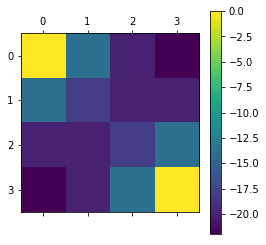

In [ ]:
init_policy = np.ones((env.nS,env.nA))/env.nA
#for s in range(env.nS):
 # init_policy[s] = softmax(init_policy[s])
v = policy_eval(init_policy,env,1.0,0.0001)
import matplotlib.pyplot as plt
plt.matshow(v.reshape(4,4))
plt.colorbar()
print(v.reshape(4,4))

In [ ]:
print(init_policy)

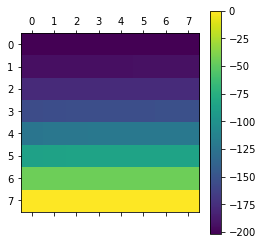

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(v.reshape(8,8))
plt.colorbar()

In [ ]:
a = [1,5,7,4,5,7,1,5,7,3,1]
print(a.index(max(a)))

2
